In [1]:
!pip install holidays

In [2]:
import holidays
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import numpy as np

from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from datetime import timedelta

from google.colab import files
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline

In [3]:
calendar = holidays.RU(years =[2016,2020])

In [4]:
# files.upload()
# !ls

In [67]:
# Файл с курсом евро относительно доллара на торгах на московской бирже с 01.01.2016 по 02.09.2020 г.
df = pd.read_csv('EURUSD000TOD_160101_200901.csv', sep = ',', parse_dates=[0])
df.head()

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,2016-01-11,0,1.09350,1.09355,1.08685,1.08840,10767000
1,2016-01-12,0,1.08960,1.09090,1.08500,1.08725,880000
2,2016-01-13,0,1.08295,1.08420,1.08035,1.08300,15532000
3,2016-01-14,0,1.08590,1.09425,1.08590,1.09400,961000
4,2016-01-15,0,1.08800,1.09215,1.08800,1.08950,849000


In [68]:
df.drop(columns='<TIME>', inplace=True)
df.rename(columns={'<DATE>': 'date','<OPEN>': 'open', '<HIGH>': 'high', '<LOW>': 'low', '<CLOSE>': 'close', '<VOL>': 'vol'}, inplace=True)
df.tail()

,date,open,high,low,close,vol
1088,2020-08-27,1.18250,1.18500,1.17970,1.18130,7377000
1089,2020-08-28,1.18678,1.19199,1.18678,1.19080,7171000
1090,2020-08-31,1.20000,1.20022,1.18202,1.19399,3438000
1091,2020-09-01,1.18601,1.19950,1.18600,1.19900,2549000
1092,2020-09-02,1.19000,1.19000,1.18504,1.18539,3046000


In [69]:
#инициализировали объект календарь

one_day = timedelta(days=1)
df['is_prev_holiday'] = df['date'].isin([( d - one_day ) for d in calendar.keys()])
df['is_next_holiday'] = df['date'].isin([( d + one_day ) for d in calendar.keys()])
df['is_prev_holiday'] = df['is_prev_holiday'].astype('uint8')
df['is_next_holiday'] = df['is_next_holiday'].astype('uint8')

In [70]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['weekofyear'] = df['date'].dt.weekofyear
df['dayofmonth'] = df['date'].dt.day
df['quarter'] = df['date'].dt.quarter
df['dayofyear'] = df['date'].dt.dayofyear
df['dayofweek'] = df['date'].dt.dayofweek
df.index = df['date']
df = df.drop('date', axis = 1)
df.head()

,open,high,low,close,vol,is_prev_holiday,is_next_holiday,year,month,weekofyear,dayofmonth,quarter,dayofyear,dayofweek
date,,,,,,,,,,,,,,
2016-01-11,1.09350,1.09355,1.08685,1.08840,10767000,0,0,2016,1,2,11,1,11,0
2016-01-12,1.08960,1.09090,1.08500,1.08725,880000,0,0,2016,1,2,12,1,12,1
2016-01-13,1.08295,1.08420,1.08035,1.08300,15532000,0,0,2016,1,2,13,1,13,2
2016-01-14,1.08590,1.09425,1.08590,1.09400,961000,0,0,2016,1,2,14,1,14,3
2016-01-15,1.08800,1.09215,1.08800,1.08950,849000,0,0,2016,1,2,15,1,15,4


In [71]:
target_name = 'high'
target_index = df.columns.get_loc(target_name)
target_index

1

In [72]:
data_names = df.columns.to_list()
data_names

['open',
 'high',
 'low',
 'close',
 'vol',
 'is_prev_holiday',
 'is_next_holiday',
 'year',
 'month',
 'weekofyear',
 'dayofmonth',
 'quarter',
 'dayofyear',
 'dayofweek']

In [73]:
# Период, который будем использовать для осуществления прогноз

history_for_predict = 5

# шаг на котором будет осуществляться прогноз прогноза
prediction_step = 1

# Сдвиг для прогноза

target_shift = history_for_predict + prediction_step

past_history = 30
future_history = 7
split_point = df.shape[0] - past_history - future_history
split_point

1056

In [74]:
# Нормализация данных

def normalize(data, train_split):
    data_mean = data[:train_split - 1].mean(axis=0)
    data_std = data[:train_split - 1].std(axis=0)
    return (data - data_mean) / data_std

# Разделение данных на тренировочную и тестовую части

def split_data(data, split_point, target_shift, target_name):
  x_train = data.iloc[0 : split_point - 1 - target_shift].copy()
  x_test = data.iloc[split_point: -target_shift].copy()
  y_train = data.iloc[target_shift : split_point - 1][target_name].copy()
  y_test = data.iloc[split_point + target_shift:][target_name].copy()
  return x_train, x_test, y_train, y_test
  

In [75]:
normalized_df = pd.DataFrame(normalize(df.values, split_point), columns=data_names)
normalized_df.head()

,open,high,low,close,vol,is_prev_holiday,is_next_holiday,year,month,weekofyear,dayofmonth,quarter,dayofyear,dayofweek
0,-0.875480,-0.916649,-0.988760,-0.989207,-0.106862,-0.061692,-0.061692,-1.349,-1.59151,-1.641758,-0.591871,-1.313475,-1.636344,-1.499469
1,-0.966231,-0.978192,-1.031885,-1.015941,-0.974512,-0.061692,-0.061692,-1.349,-1.59151,-1.641758,-0.476301,-1.313475,-1.626540,-0.775800
2,-1.120972,-1.133792,-1.140280,-1.114737,0.311298,-0.061692,-0.061692,-1.349,-1.59151,-1.641758,-0.360731,-1.313475,-1.616737,-0.052132
3,-1.052327,-0.900392,-1.010905,-0.859028,-0.967404,-0.061692,-0.061692,-1.349,-1.59151,-1.641758,-0.245161,-1.313475,-1.606933,0.671537
4,-1.003462,-0.949162,-0.961953,-0.963637,-0.977233,-0.061692,-0.061692,-1.349,-1.59151,-1.641758,-0.129592,-1.313475,-1.597129,1.395206


In [76]:
x_train, x_test, y_train, y_test = split_data(normalized_df, split_point, target_shift, target_name)

In [77]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1049, 14)
(31, 14)
(1049,)
(31,)


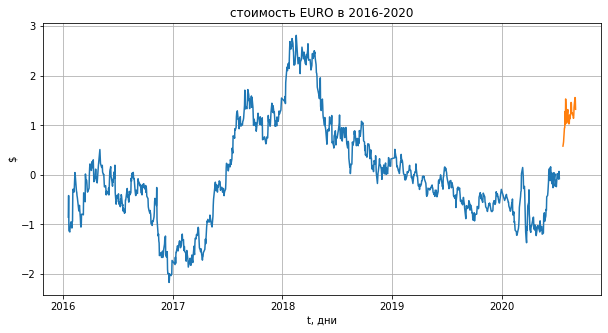

In [78]:
plt.figure(figsize=(10,5))
plt.plot(df.index[target_shift:split_point - 1],y_train)
plt.plot(df.index[split_point+target_shift:],y_test)
plt.grid('on')
plt.xlabel('t, дни')
plt.ylabel('$')
plt.title('стоимость EURO в 2016-2020')
plt.show()

In [79]:
# параметры модели для обучения

learning_rate = 0.001
batch_size = 32
epochs = 10

In [80]:
# Используем механизм формирования пакетов для обучения

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=history_for_predict,
    sampling_rate=1,
    batch_size=batch_size,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_test,
    y_test,
    sequence_length=history_for_predict,
    sampling_rate=1,
    batch_size=batch_size,
)

In [81]:
# Посмотрим, что получилось

for batch in dataset_train.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (32, 5, 14)
Target shape: (32,)


In [82]:
inputs[2,:,target_index]

<tf.Tensor: shape=(5,), dtype=float64, numpy=array([-1.04437985, -0.79588471, -0.80052948, -0.80749663, -0.36392118])>

In [83]:
targets[0]

<tf.Tensor: shape=(), dtype=float64, numpy=-0.36392118044234706>

In [84]:
# Строим сеть : LSTM слои + Conv1D + Dense слой.

callback = EarlyStopping(monitor='val_mae', patience=5) # ранний останов

model = Sequential()

model.add(LSTM(32, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(LSTM(32, return_sequences="True"))
model.add(Conv1D(64, 3, activation="linear"))
model.add(Conv1D(64, 3, activation="linear"))
model.add(Flatten())
model.add(Dense(3, activation="linear"))
model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callback])

Epoch 1/10
33/33 [==============================] - 1s 36ms/step - loss: 0.4583 - mae: 0.5320 - val_loss: 0.8820 - val_mae: 0.8469
Epoch 2/10
33/33 [==============================] - 0s 12ms/step - loss: 0.2427 - mae: 0.3955 - val_loss: 0.6758 - val_mae: 0.8046
Epoch 3/10
33/33 [==============================] - 0s 13ms/step - loss: 0.2675 - mae: 0.4164 - val_loss: 0.6632 - val_mae: 0.7093
Epoch 4/10
33/33 [==============================] - 0s 13ms/step - loss: 0.2074 - mae: 0.3711 - val_loss: 0.6122 - val_mae: 0.7647
Epoch 5/10
33/33 [==============================] - 0s 13ms/step - loss: 0.2524 - mae: 0.3985 - val_loss: 0.4937 - val_mae: 0.5967
Epoch 6/10
33/33 [==============================] - 0s 13ms/step - loss: 0.1735 - mae: 0.3304 - val_loss: 0.7504 - val_mae: 0.8479
Epoch 7/10
33/33 [==============================] - 0s 13ms/step - loss: 0.2175 - mae: 0.3747 - val_loss: 0.2674 - val_mae: 0.4456
Epoch 8/10
33/33 [==============================] - 0s 13ms/step - loss: 0.1500 - m

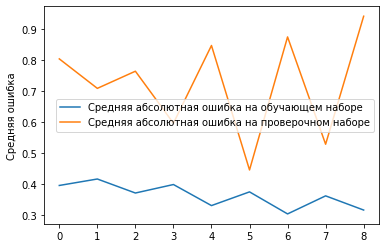

In [85]:
plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [86]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

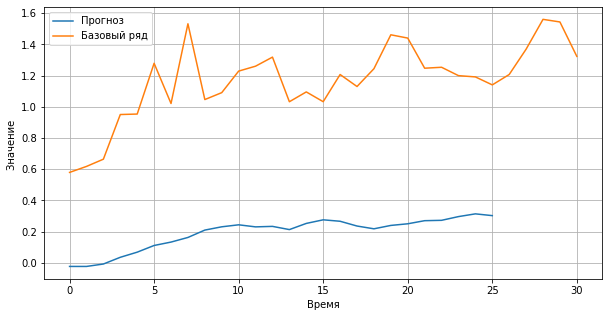

In [87]:
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal[prediction_step:], 
         label='Прогноз')
plt.plot(y_test.values.flatten()[:], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()